# **The Many Faces of Hurricanes: The Influence of AMO, ENSO, and Higher-Order Moment Analysis**

## **Introduction**
> *"If you know where the wind comes from, you can predict where it will take you."*  
> — A Meteorologist  

Hurricanes, one of the most destructive natural phenomena on Earth 🌍, have shown changes in frequency, intensity, and trajectory under global warming. Scientists have long been investigating these variations, seeking to understand the key climate drivers behind them.  

This study focuses on **the Atlantic Multidecadal Oscillation (AMO) and the El Niño-Southern Oscillation (ENSO)**, combining **hurricane higher-order moment (mass moments) analysis with K-Means clustering** to uncover patterns in hurricane behavior and anticipate future trends.

---

## **1. The Climate Signals Behind Hurricanes**
The formation and development of hurricanes are influenced by multiple large-scale climate factors, with **AMO and ENSO being two of the most critical**.

### **1.1 📖 What is AMO (Atlantic Multidecadal Oscillation)?**
AMO refers to **long-term oscillations in North Atlantic sea surface temperature (SST)**, typically lasting **20-40 years**. It has two phases:
- **Positive Phase (Warm Cycle)**: Warmer-than-average SST in the North Atlantic.
  - Increases hurricane activity by providing more heat and moisture.
  - Leads to stronger and more frequent hurricanes.
  - Causes hurricanes to follow a more **westward** trajectory, making landfall in North America more likely.

- **Negative Phase (Cold Cycle)**: Cooler-than-average SST in the North Atlantic.
  - Suppresses hurricane development.
  - Results in fewer hurricanes, generally weaker in intensity.
  - Causes hurricanes to stay farther east over the ocean, reducing landfall probability.

### **1.2 📖 What is ENSO (El Niño-Southern Oscillation)?**
ENSO is a **climate phenomenon in the tropical Pacific** that influences global atmospheric circulation. It has two major phases:
- **El Niño (Warm Phase)**:
  - Warmer SST in the central and eastern Pacific.
  - Increases wind shear over the Atlantic, **suppressing hurricane activity**.
  - Leads to **fewer hurricanes**, weaker storms, and eastward-shifted hurricane tracks.

- **La Niña (Cold Phase)**:
  - Cooler SST in the central and eastern Pacific.
  - Reduces wind shear, **enhancing hurricane development**.
  - Leads to **more hurricanes**, stronger storms, and westward-shifted hurricane tracks.


### Next Station ➡️ Part 2 ！

## **2.AMO Analysis**

Before we start to the AMO code, let's first guess what effect the AMO will have on hurricanes. 🌬️ 🌊
- Will the warm phase🔥 increase or decrease the number of hurricanes?
- What is the hurricane grade?
- What about the cold phase 🧊?

Have you guessed them? 🤔 Now, let's find them out!!!

#### **2.1 AMO Research Code**

First, we clean and process the Hurricane and AMO data from the NA basin. 

In [1]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)

In [2]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [3]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [4]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

Request failed: HTTPSConnectionPool(host='www.ncei.noaa.gov', port=443): Read timed out. (read timeout=60)


In [5]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

Next, we plot and visualize the Atlantic Multi-Decadal Oscillation (AMO) Index use a Smoothed Trend from 1860 to 2020

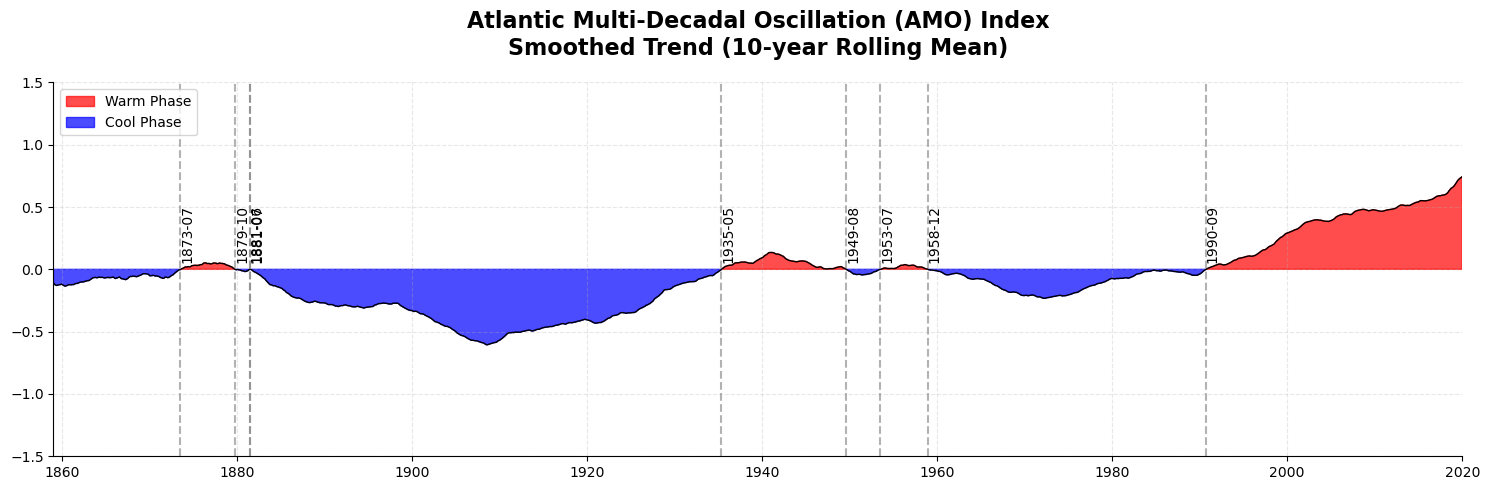

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

# Load and calculate 10-year moving average
def load_and_process_amo(file_path):
    # Read AMO data
    AMO_time = pd.read_csv(file_path, sep=r'\s+', skiprows=2, names=["Year", "Month", "SSTA"])
    
    # Convert data types
    AMO_time = AMO_time.astype({"Year": int, "Month": int, "SSTA": float})
    
    # Create date column
    AMO_time["Date"] = pd.to_datetime(AMO_time["Year"].astype(str) + "-" + 
                                    AMO_time["Month"].astype(str).str.zfill(2))
    
    # Calculate 10-year moving average (121 months)
    AMO_time["AMO_Smoothed"] = AMO_time["SSTA"].rolling(window=121, center=True).mean()
    
    # Remove missing values
    AMO_time = AMO_time.dropna(subset=["AMO_Smoothed"])
    
    return AMO_time

def plot_amo_index(AMO_time):
    # Find zero crossings
    zero_crossings = np.where(np.diff(np.sign(AMO_time['AMO_Smoothed'])))[0]
    zero_dates = AMO_time.iloc[zero_crossings]['Date']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot filled areas
    ax.fill_between(AMO_time['Date'], AMO_time['AMO_Smoothed'], 0,
                    where=(AMO_time['AMO_Smoothed'] > 0),
                    color='red', alpha=0.7, label='Warm Phase')
    ax.fill_between(AMO_time['Date'], AMO_time['AMO_Smoothed'], 0,
                    where=(AMO_time['AMO_Smoothed'] <= 0),
                    color='blue', alpha=0.7, label='Cool Phase')
    
    # Plot black line
    ax.plot(AMO_time['Date'], AMO_time['AMO_Smoothed'], color='black', linewidth=1)
    
    # Add vertical lines and labels at zero crossings
    for date in zero_dates:
        ax.axvline(date, color='gray', linestyle='dashed', alpha=0.6)
        # Format date label as "YYYY-MM"
        date_label = date.strftime('%Y-%m')
        ax.text(date, 0.05, date_label, rotation=90, 
                verticalalignment='bottom', fontsize=10)
    
    # Set title and style
    ax.set_title("Atlantic Multi-Decadal Oscillation (AMO) Index\n" + 
                 "Smoothed Trend (10-year Rolling Mean)", 
                 fontsize=16, fontweight="bold", pad=20)
    
    # Set x-axis
    ax.xaxis.set_major_locator(YearLocator(20))  # One tick every 20 years
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    
    # Set figure limits
    ax.set_xlim(AMO_time['Date'].min(), AMO_time['Date'].max())
    ax.set_ylim(-1.5, 1.5)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="upper left")
    
    plt.tight_layout()
    return fig

# Use functions
file_path = "ersst.v5.amo.dat.txt"  # Replace with your file path
AMO_time = load_and_process_amo(file_path)
fig = plot_amo_index(AMO_time)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

def categorize_hurricane(max_wind_speed):
    """Classify hurricanes based on maximum wind speed"""
    if 34 <= max_wind_speed < 64:
        return "Tropical Storm"
    elif max_wind_speed < 83:
        return "Category 1"
    elif max_wind_speed < 96:
        return "Category 2"
    elif max_wind_speed < 113:
        return "Category 3"
    elif max_wind_speed < 137:
        return "Category 4"
    else:
        return "Category 5"

def plot_phase_comparison(df, save_path=None):
    """
    Plot phase comparison between cold and warm phases
    """
    # Create a 6x2 grid of subplots
    fig = plt.figure(figsize=(20, 30))
    
    # Define categories and colors
    category_colors = {
        "Tropical Storm": (144/255, 238/255, 144/255),    # Light green
        "Category 1": (238/255, 232/255, 170/255),        # Light yellow
        "Category 2": (244/255, 164/255, 96/255),         # Light orange
        "Category 3": (233/255, 150/255, 122/255),        # Light red
        "Category 4": (221/255, 160/255, 221/255),        # Light purple
        "Category 5": (147/255, 112/255, 219/255)         # Dark purple
    }
    
    categories = ["Category 5", "Category 4", "Category 3", 
                  "Category 2", "Category 1", "Tropical Storm"]
    phases = ["Cold phase", "Warm phase"]
    
    for cat_idx, category in enumerate(categories):
        for phase_idx, phase in enumerate(phases):
            ax = plt.subplot(6, 2, cat_idx*2 + phase_idx + 1, projection=ccrs.PlateCarree())
            
            # Set map extent
            ax.set_extent([-100, 0, 0, 60], crs=ccrs.PlateCarree())
            
            # Add natural geographic features
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', 
                                                         edgecolor='face', 
                                                         facecolor=cfeature.COLORS['water']))
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                                         edgecolor='face',
                                                         facecolor=cfeature.COLORS['land']))
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.COASTLINE)
            
            # Add gridlines
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                              alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False if phase_idx == 0 else False
            gl.left_labels = True if phase_idx == 0 else False
            
            # Filter data
            storm_ids = df[df['Category'] == category]['Storm_ID'].unique()
            storm_data = df[df['Storm_ID'].isin(storm_ids) & (df['AMO_Phase'] == phase)]
            
            if len(storm_data) > 0:
                plotted_storms = set()
                for storm_id in storm_data['Storm_ID'].unique():
                    if storm_id in plotted_storms:
                        continue
                        
                    track = df[df['Storm_ID'] == storm_id].sort_values('ISO_Time')
                    track = track.iloc[::16, :]  # Reduce point density
                    
                    # Plot track line
                    ax.plot(track['Longitude'], track['Latitude'],
                           color='black',
                           linewidth=0.8,
                           alpha=0.4,
                           zorder=2)
                    
                    # Add points
                    ax.scatter(track['Longitude'], track['Latitude'],
                               color=category_colors[category],
                               s=15,
                               alpha=0.6,
                               edgecolor='black',
                               linewidth=0.5,
                               zorder=3)
                    
                    plotted_storms.add(storm_id)
            
            # Add subplot title
            storm_count = len(set(storm_data['Storm_ID']))
            ax.set_title(f"{category} - {phase}\n({storm_count} storms)", 
                         fontsize=12, pad=10)
    
    # Add overall title
    plt.suptitle("1950-2020 North Atlantic Hurricanes\nPhase Comparison", 
                 fontsize=16, y=0.92)
    
    # Adjust subplot spacing
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def main():
    # Read data
    df = pd.read_csv('updated_storm_data.csv')
    
    # Handle date format more flexibly
    try:
        df['Year'] = pd.to_datetime(df['ISO_Time'], format='mixed').dt.year
    except:
        # If the above method fails, try extracting the year directly from Storm_ID
        df['Year'] = df['Storm_ID'].str[:16].astype(int)
    
    # Restrict time range to 1950-2020
    df = df[(df['Year'] >= 1950) & (df['Year'] <= 2020)]
    
    # Get the maximum intensity for each storm
    max_intensities = df.groupby('Storm_ID')['Storm_Intensity'].max()
    df['Category'] = df['Storm_ID'].map(lambda x: categorize_hurricane(max_intensities[x]))
    
    # Add AMO phase
    df['AMO_Phase'] = df['AMO_Anomaly'].apply(lambda x: 'Warm phase' if x > 0 else 'Cold phase')
    
    # Generate phase comparison plot
    plot_phase_comparison(df)

if __name__ == "__main__":
    main()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime

def categorize_hurricane(max_wind_speed):
    """Classify hurricanes based on maximum wind speed"""
    if 34 <= max_wind_speed < 64:
        return "Tropical Storm"
    elif max_wind_speed < 83:
        return "Category 1"
    elif max_wind_speed < 96:
        return "Category 2"
    elif max_wind_speed < 113:
        return "Category 3"
    elif max_wind_speed < 137:
        return "Category 4"
    else:
        return "Category 5"

# Read and process data
df = pd.read_csv('merged_amo.csv')

# Limit time range to 1950-2020
df['Date'] = pd.to_datetime(df['ISO_Time'])
df['Year'] = df['Date'].dt.year
df = df[(df['Year'] >= 1950) & (df['Year'] <= 2020)]

# Calculate maximum intensity for each storm
max_intensities = df.groupby('Storm_ID')['Storm_Intensity'].max()
unique_storms = df.drop_duplicates('Storm_ID').copy()
unique_storms['Max_Intensity'] = unique_storms['Storm_ID'].map(max_intensities)
unique_storms['Category'] = unique_storms['Storm_ID'].map(lambda x: categorize_hurricane(max_intensities[x]))
unique_storms['AMO_Phase'] = unique_storms['AMO_Anomaly'].apply(lambda x: 'Warm phase' if x > 0 else 'Cold phase')

# Create yearly statistics
yearly_data = pd.DataFrame(index=range(1950, 2021))
yearly_data['AMO_Phase'] = unique_storms.groupby('Year')['AMO_Phase'].first()

# Calculate the number of years for each phase
phase_years = yearly_data['AMO_Phase'].value_counts()

# Create figure
fig = plt.figure(figsize=(20, 15))

# Define colors
category_colors = {
    "Tropical Storm": (144/255, 238/255, 144/255),    # Light green
    "Category 1": (238/255, 232/255, 170/255),        # Light yellow
    "Category 2": (244/255, 164/255, 96/255),         # Light orange
    "Category 3": (233/255, 150/255, 122/255),        # Light red
    "Category 4": (221/255, 160/255, 221/255),        # Light purple
    "Category 5": (147/255, 112/255, 219/255)         # Dark purple
}

phase_colors = ['#99CCFF', '#FF9999']  # Colors for cold and warm phases

# 1. Category distribution
plt.subplot(2, 2, 1)
category_order = ["Category 5", "Category 4", "Category 3", 
                 "Category 2", "Category 1", "Tropical Storm"]
cat_counts = pd.crosstab(unique_storms['AMO_Phase'], unique_storms['Category'])

# Calculate the average number of storms per year for each phase
for phase in cat_counts.index:
    cat_counts.loc[phase] = cat_counts.loc[phase] / phase_years[phase]

cat_counts = cat_counts[category_order]

ax = cat_counts.plot(kind='bar', ax=plt.gca(), 
                    color=[category_colors[cat] for cat in category_order])
plt.title('Average Annual Hurricane Category Distribution by AMO Phase\n(1950-2020)', 
         fontsize=14, pad=20)
plt.xlabel('AMO Phase', fontsize=12)
plt.ylabel('Average Number of Storms per Year', fontsize=12)
plt.legend(title='Hurricane Category', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# 2. Monthly distribution
plt.subplot(2, 2, 2)
unique_storms['Month'] = unique_storms['Date'].dt.month
monthly_counts = pd.crosstab(unique_storms['AMO_Phase'], unique_storms['Month'])

# Ensure all months are present; if missing, fill with 0
for month in range(1, 13):
    if month not in monthly_counts.columns:
        monthly_counts[month] = 0
monthly_counts = monthly_counts.reindex(columns=range(1, 13)).fillna(0)

# Calculate average monthly distribution for each phase
for phase in monthly_counts.index:
    monthly_counts.loc[phase] = monthly_counts.loc[phase] / phase_years[phase]

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, phase in enumerate(monthly_counts.index):
    plt.plot(range(len(month_names)), monthly_counts.loc[phase], 
            marker='o', label=phase, color=phase_colors[i], linewidth=2)
plt.title('Average Monthly Hurricane Distribution by AMO Phase\n(1950-2020)', 
         fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Number of Storms per Year', fontsize=12)
plt.legend()
plt.xticks(range(len(month_names)), month_names, rotation=45)
plt.grid(True, alpha=0.3)

# 3. Maximum intensity distribution (Violin plot)
plt.subplot(2, 2, 3)
sns.violinplot(data=unique_storms, x='AMO_Phase', y='Max_Intensity', 
               palette=phase_colors)
plt.title('Maximum Storm Intensity Distribution by AMO Phase\n(1950-2020)', 
         fontsize=14, pad=20)
plt.xlabel('AMO Phase', fontsize=12)
plt.ylabel('Maximum Storm Intensity (knots)', fontsize=12)
plt.grid(True, alpha=0.3)

# 4. Relationship between maximum intensity and AMO anomaly
plt.subplot(2, 2, 4)

# Create color gradient
plt.scatter(unique_storms['AMO_Anomaly'], unique_storms['Max_Intensity'], 
           c=unique_storms['AMO_Anomaly'],
           cmap='RdBu_r',
           alpha=0.6,
           s=30)

# Add regression line
z = np.polyfit(unique_storms['AMO_Anomaly'], unique_storms['Max_Intensity'], 1)
p = np.poly1d(z)
x_range = np.linspace(unique_storms['AMO_Anomaly'].min(), 
                     unique_storms['AMO_Anomaly'].max(), 100)
plt.plot(x_range, p(x_range), color='black', linestyle='--', alpha=0.5)

# Add correlation coefficient
correlation = np.corrcoef(unique_storms['AMO_Anomaly'], unique_storms['Max_Intensity'])[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=10)

plt.title('Maximum Storm Intensity vs AMO Anomaly\n(1950-2020)', 
         fontsize=14, pad=20)
plt.xlabel('AMO Anomaly', fontsize=12)
plt.ylabel('Maximum Storm Intensity (knots)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary (1950-2020):")
print(f"\nAnalysis period: 1950-2020 ({len(yearly_data)} years)")
print(f"- Warm phase: {phase_years['Warm phase']} years")
print(f"- Cold phase: {phase_years['Cold phase']} years")
print("\nTotal number of storms:")
print(unique_storms['AMO_Phase'].value_counts())
print("\nAverage number of storms per year:")
for phase in phase_years.index:
    storms_in_phase = len(unique_storms[unique_storms['AMO_Phase'] == phase])
    avg_storms = storms_in_phase / phase_years[phase]
    print(f"{phase}: {avg_storms:.2f}")
    

print("\n1. Average Annual Hurricane Count by Intensity Category:")
print("\nStrong hurricanes (Categories 3-5):")
strong_storms = cat_counts[['Category 5', 'Category 4', 'Category 3']]
print(strong_storms.sum(axis=1))

print("\nModerate hurricanes (Categories 1-2):")
medium_storms = cat_counts[['Category 2', 'Category 1']]
print(medium_storms.sum(axis=1))

print("\nTropical Storms:")
ts_storms = cat_counts['Tropical Storm']
print(ts_storms)

print("\n2. Average Maximum Intensity:")
print(unique_storms.groupby('AMO_Phase')['Max_Intensity'].agg(['mean', 'std', 'count']))

print("\n3. Average Annual Storm Count During Peak Months (Aug-Oct):")
peak_months = monthly_counts[[8,9,10]]
print("Average monthly values during peak period:")
print(peak_months)
print("\nTotal during peak period:")
print(peak_months.sum(axis=1))

### **2.2 AMO Research Conclusions**

During the analysis period from **1950 to 2020** (a total of **71 years**), although the **cold phase** ❄️ lasted longer (**41 years, 634 storms**), the **annual average number of storms** was higher during the **warm phase** 🔥 (**30 years**), reaching **16.73 storms per year**, compared to **15.46 storms per year** in the cold phase. This indicates that **storm activity was more concentrated during the warm phase**.

#### 1） Frequency of Major Hurricanes (Categories 3–5)
- **During the warm phase** 🔥:  
  - The annual average number of **major hurricanes (Categories 3–5)** was **3.50**.  
- **During the cold phase** ❄️:  
  - The annual average number of **major hurricanes (Categories 3–5)** was **only 2.20**.  
- **🔎 Conclusion**: **Major hurricanes tend to form more frequently under warm phase conditions.**  

---

#### 2） Frequency of Moderate Hurricanes (Categories 1–2) and Tropical Storms
- **During the cold phase** ❄️:  
  - 🌀 **Categories 1–2 hurricanes**: **8.07 per year**.  
  - 🌊 **Tropical storms**: **5.20 per year**.  
- **During the warm phase** 🔥:  
  - 🌀 **Categories 1–2 hurricanes**: **6.33 per year**.  
  - 🌊 **Tropical storms**: **6.90 per year**.  
- **🔎 Conclusion**: **Moderate-intensity hurricanes were more frequent during the cold phase, while tropical storms were more frequent during the warm phase**, indicating a **significant difference in storm intensity distribution** between the two phases.  

---

#### 3） Maximum Storm Intensity 💨
- **During the warm phase** 🔥:  
  - The **average maximum storm intensity** reached **69.05 knots**.  
- **During the cold phase** ❄️:  
  - The **average maximum storm intensity** was only **58.82 knots**.  
- **🔎 Conclusion**: **Storms not only occurred more frequently during the warm phase, but they were also more intense.**  

---

#### 4） Hurricane Peak Season (August–October) ⏳
- **During the warm phase** 🔥:  
  - The total number of storms in the **peak hurricane season (August–October)** was **12.23 per year**, higher than **10.98 per year** in the cold phase.  
  - **The difference was particularly pronounced in August** 📈.  
- **🔎 Conclusion**: **Storm activity during the peak hurricane season was significantly higher during the warm phase, further amplifying regional storm risk.**  

---

#### 🏁 Summary 🎯
📊 These statistical findings suggest that **the warm phase of the Atlantic Multidecadal Oscillation (AMO) not only leads to a higher annual storm frequency but also promotes the development of more intense hurricanes**, thereby **exerting a greater impact on regional storm risk** ⚠️.  

## **3.ENSO Analysis**

#### **3.1 Processing and cleaning ENSO and Hurricane data in NA basin**

First, we load the necessary libraries.

In [ ]:
# Load all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import os
import requests
import urllib.request
import IPython.display as display
from sklearn.preprocessing import StandardScaler
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Then, we proccessed and load the data from ENSO and Hurricanes in NA basin from 1950 to 2020. 

In [ ]:
# Define file paths
data_dir = "../project1"
hurricane_nc_path = os.path.join(data_dir, "IBTrACS.NA.v04r00.nc")
enso_path = os.path.join(data_dir, "enso_data.txt")

# Ensure the data directory exists
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download IBTrACS Hurricane Data if not found
ibtracs_url = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc"

if not os.path.exists(hurricane_nc_path):
    print("Downloading IBTrACS hurricane data...")
    try:
        response = requests.get(ibtracs_url, timeout=60)
        response.raise_for_status()  # Raise an error if the request failed
        with open(hurricane_nc_path, "wb") as f:
            f.write(response.content)
        print("IBTrACS file downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")

# Load NetCDF hurricane data
try:
    ds = xr.open_dataset(hurricane_nc_path)
except Exception as e:
    print(f"Request failed: {e}")

# Convert NetCDF dataset to Pandas DataFrame
df_hurricane = ds.to_dataframe().reset_index()

# Select relevant columns based on dataset structure
df_hurricane = df_hurricane.loc[:, ["sid", "season", "time", "lat", "lon", "usa_wind"]].copy()

# Rename columns for clarity
df_hurricane.columns = ["Storm_ID", "Year", "ISO_Time", "Latitude", "Longitude", "Storm_Intensity"]

# Decode `sid` from bytes to string
df_hurricane["Storm_ID"] = df_hurricane["Storm_ID"].str.decode("utf-8")

# Convert Year to integer (from float)
df_hurricane["Year"] = df_hurricane["Year"].astype(int)

# Filter years from 1950 onwards
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Convert `ISO_Time` to datetime format
df_hurricane["ISO_Time"] = pd.to_datetime(df_hurricane["ISO_Time"], errors="coerce")

# Drop rows where conversion failed
df_hurricane = df_hurricane.dropna(subset=["ISO_Time"])

# Extract Month safely
df_hurricane["Month"] = df_hurricane["ISO_Time"].dt.month.astype(int)

# Convert Month from number to text for merging with ENSO
month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_hurricane["Month"] = df_hurricane["Month"].map(month_map)

# Define hurricane category mapping (based on wind speed in knots)
def categorize_hurricane(wind_speed):
    if wind_speed < 64:
        return "Tropical Storm"
    elif 64 <= wind_speed <= 82:
        return "Category 1"
    elif 83 <= wind_speed <= 95:
        return "Category 2"
    elif 96 <= wind_speed <= 112:
        return "Category 3"
    elif 113 <= wind_speed <= 136:
        return "Category 4"
    else:
        return "Category 5"

# Apply category mapping
df_hurricane["Category"] = df_hurricane["Storm_Intensity"].apply(categorize_hurricane)

# Save the cleaned dataset
df_hurricane.to_csv("../project1/hurricane_cleaned.csv", index=False)

In [ ]:
#Cleaning ENSO table

# Load ENSO data
df_enso = pd.read_csv(enso_path, sep=r'\s+', header=None)

# Rename columns
df_enso.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Remove non-numeric rows (e.g., headers, footers)
df_enso = df_enso[df_enso["Year"].astype(str).str.match(r'^\d{4}$')]

# Convert Year to integer
df_enso["Year"] = df_enso["Year"].astype(int)

# Convert to long format
df_enso_long = df_enso.melt(id_vars=["Year"], var_name="Month", value_name="SST_Anomaly")

# Convert SST_Anomaly to numeric
df_enso_long["SST_Anomaly"] = pd.to_numeric(df_enso_long["SST_Anomaly"], errors="coerce")

# Sort values (important for applying 5-month rule)
df_enso_long = df_enso_long.sort_values(by=["Year", "Month"]).reset_index(drop=True)

# Initialize ENSO phase column
df_enso_long["ENSO_Phase"] = "Neutral"

# Function to apply 5-month rule
def detect_enso_events(df):
    consecutive_count = 0
    current_phase = "Neutral"
    
    for i in range(len(df)):
        anomaly = df.loc[i, "SST_Anomaly"]

        # Determine the phase for this month
        if anomaly >= 0.5:
            phase = "El Niño"
        elif anomaly <= -0.5:
            phase = "La Niña"
        else:
            phase = "Neutral"

        # If we are continuing the same phase, increase count
        if phase == current_phase:
            consecutive_count += 1
        else:
            # If we switch phases, reset the counter
            consecutive_count = 1
            current_phase = phase

        # If phase has lasted for at least 5 months, apply to previous months
        if consecutive_count >= 5:
            for j in range(i - 4, i + 1):
                df.loc[j, "ENSO_Phase"] = current_phase  # Apply to previous 5 months

    return df

# Apply 5-month rule
df_enso_long = detect_enso_events(df_enso_long)
df_enso_long.to_csv("../project1/enso_cleaned.csv", index=False)

Next, we had to merge the ENSO and Hurricane data together to show the ENSO phases for each hurricane.

In [ ]:
#merge ENSO and hurricane data together
df_hurricane["Year"] = df_hurricane["Year"].astype(int)
df_hurricane["Month"] = df_hurricane["Month"].astype(str)

df_enso_long["Year"] = df_enso_long["Year"].astype(int)
df_enso_long["Month"] = df_enso_long["Month"].astype(str)
df_enso_long = df_enso_long[df_enso_long["Year"] >= 1950]

# Define a dictionary to map abbreviated month names to full names
month_map = {
    "Jan": "January", "Feb": "February", "Mar": "March", "Apr": "April", "May": "May", "Jun": "June",
    "Jul": "July", "Aug": "August", "Sep": "September", "Oct": "October", "Nov": "November", "Dec": "December"
}

# Apply the mapping
df_hurricane["Month"] = df_hurricane["Month"].map(month_map)
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].map(month_map)

# Ensure all Month values are consistent by stripping spaces
df_hurricane["Month"] = df_hurricane["Month"].str.strip()
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].str.strip()

# Convert to lowercase (optional but helps prevent mismatches)
df_hurricane["Month"] = df_hurricane["Month"].str.capitalize()
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].str.capitalize()
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Merge hurricane data with ENSO data on Year & Month
df_merged_ENSO = df_hurricane.merge(df_enso_long, on=["Year", "Month"], how="left")

# Save merged dataset
df_merged_ENSO.to_csv("../project1/merged_enso.csv", index=False)

#### **3.2 ENSO and Hurricane Visualizations**

We classified the ENSO phases using the 5-month rule. If the surface sea temperature (SST) maintained a certain threshold over a 5-month period, then we classified a phase as El Nino, La Nina, or neutral for at least 5 consecutive overlapping 3-month averages.

In [ ]:
#ENSO visualization over years

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Aggregate by Month (Average SST anomaly per month across years)
df_monthly = df_enso_long.groupby(["Year", "Month"])["SST_Anomaly"].mean().reset_index()

# Set up figure
plt.figure(figsize=(12, 6))

# Define ENSO colors
enso_colors = df_monthly["SST_Anomaly"].apply(lambda x: "red" if x >= 0.5 else "blue" if x <= -0.5 else "gray")

# Create bar plot for monthly SST anomalies
plt.bar(df_monthly.index, df_monthly["SST_Anomaly"], color=enso_colors, width=1.0, alpha=0.7)

# Add smoothed 5-year rolling mean to show ENSO variability over time
df_monthly["Rolling_MEI"] = df_monthly["SST_Anomaly"].rolling(60, min_periods=1).mean()
plt.plot(df_monthly.index, df_monthly["Rolling_MEI"], color="black", linewidth=1.5, label="Smoothed ENSO Index (5-Year Rolling Mean)")

# Add zero reference line
plt.axhline(0, color="black", linewidth=1)

# Labels and title
plt.xlabel("Time (1950-2023)", fontsize=12)
plt.ylabel("SST Anomaly (°C)", fontsize=12)
plt.title("ENSO Variability Over Time (Monthly SST Anomalies)", fontsize=14, fontweight="bold")

# Format x-axis
plt.xticks(np.arange(0, len(df_monthly), step=120), df_monthly["Year"].iloc[::120].astype(int), rotation=45)  # Show every 10 years
plt.ylim(-2.5, 3)

# Add grid for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Add legend
legend_labels = [
    plt.Line2D([0], [0], color="red", linewidth=4, label="El Niño (≥ 0.5)"),
    plt.Line2D([0], [0], color="blue", linewidth=4, label="La Niña (≤ -0.5)"),
    plt.Line2D([0], [0], color="gray", linewidth=4, label="Neutral (-0.5 to 0.5)"),
    plt.Line2D([0], [0], color="black", linewidth=1.5, label="Smoothed ENSO Index")
]
plt.legend(handles=legend_labels, loc="upper left")

# Show the plot
plt.show()

Next, we plot the hurricane tracks in the NA basin according to its strongest category for El Nino, La Nina, and the neutral phases.

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

# Function to classify hurricanes based on max wind speed
def categorize_hurricane(max_wind_speed):
    """Classify hurricanes based on maximum wind speed"""
    if 34 <= max_wind_speed < 64:
        return "Tropical Storm"
    elif max_wind_speed < 83:
        return "Category 1"
    elif max_wind_speed < 96:
        return "Category 2"
    elif max_wind_speed < 113:
        return "Category 3"
    elif max_wind_speed < 137:
        return "Category 4"
    else:
        return "Category 5"

# Function to plot ENSO phase comparison
def plot_enso_comparison(df, save_path=None):
    """
    Plot hurricane tracks for different ENSO phases (El Niño, La Niña).
    """
    # Create a 6x2 grid of subplots
    fig = plt.figure(figsize=(20, 30))

    # Define categories and colors
    category_colors = {
        "Tropical Storm": (144/255, 238/255, 144/255),    # Light green
        "Category 1": (238/255, 232/255, 170/255),        # Light yellow
        "Category 2": (244/255, 164/255, 96/255),         # Light orange
        "Category 3": (233/255, 150/255, 122/255),        # Light red
        "Category 4": (221/255, 160/255, 221/255),        # Light purple
        "Category 5": (147/255, 112/255, 219/255)         # Dark purple
    }

    categories = ["Category 5", "Category 4", "Category 3", 
                  "Category 2", "Category 1", "Tropical Storm"]
    phases = ["El Niño", "La Niña"]

    for cat_idx, category in enumerate(categories):
        for phase_idx, phase in enumerate(phases):
            ax = plt.subplot(6, 2, cat_idx * 2 + phase_idx + 1, projection=ccrs.PlateCarree())

            # Set map extent
            ax.set_extent([-100, 0, 0, 60], crs=ccrs.PlateCarree())

            # Add natural geographic features
            ax.add_feature(cfeature.LAND, edgecolor='black', facecolor="beige")
            ax.add_feature(cfeature.OCEAN, facecolor=cfeature.COLORS['water'])
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.COASTLINE)

            # Add gridlines
            gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False if phase_idx == 0 else False
            gl.left_labels = True if phase_idx == 0 else False

            # Filter data
            storm_ids = df[df['Category'] == category]['Storm_ID'].unique()
            storm_data = df[df['Storm_ID'].isin(storm_ids) & (df['ENSO_Phase'] == phase)]

            if len(storm_data) > 0:
                plotted_storms = set()
                for storm_id in storm_data['Storm_ID'].unique():
                    if storm_id in plotted_storms:
                        continue

                    track = df[df['Storm_ID'] == storm_id].sort_values('ISO_Time')
                    track = track.iloc[::16, :]  # Reduce point density

                    # Plot track line
                    ax.plot(track['Longitude'], track['Latitude'],
                            color='black',
                            linewidth=0.8,
                            alpha=0.4,
                            zorder=2)

                    # Add points
                    ax.scatter(track['Longitude'], track['Latitude'],
                               color=category_colors[category],
                               s=15,
                               alpha=0.6,
                               edgecolor='black',
                               linewidth=0.5,
                               zorder=3)

                    plotted_storms.add(storm_id)

            # Add subplot title
            storm_count = len(set(storm_data['Storm_ID']))
            ax.set_title(f"{category} - {phase}\n({storm_count} storms)", fontsize=12, pad=10)

    # Add overall title
    plt.suptitle("1950-2023 North Atlantic Hurricanes by ENSO Phase", fontsize=16, y=0.92)

    # Adjust subplot spacing
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Main function
def main():
    # Read data
    df = pd.read_csv('merged_enso.csv')

    # Convert date and extract year
    df['Year'] = pd.to_datetime(df['ISO_Time']).dt.year

    # Restrict time range to 1950-2023
    df = df[(df['Year'] >= 1950) & (df['Year'] <= 2023)]

    # Get maximum intensity for each storm
    max_intensities = df.groupby('Storm_ID')['Storm_Intensity'].max()
    df['Category'] = df['Storm_ID'].map(lambda x: categorize_hurricane(max_intensities[x]))

    # Assign ENSO phase based on SST anomaly
    df['ENSO_Phase'] = df['SST_Anomaly'].apply(lambda x: 'El Niño' if x > 0.5 else 'La Niña' if x < -0.5 else 'Neutral')

    # Generate phase comparison plot
    plot_enso_comparison(df)

if __name__ == "__main__":
    main()


From this, we extracted the frequency of hurricanes for each ENSO phase

In [ ]:
#Frequency of hurricanes during different ENSO stages

# Ensure ENSO Phase is categorized correctly
df_merged_ENSO["ENSO_Phase"] = df_merged_ENSO["ENSO_Phase"].astype(str)

# Total length (years) per ENSO Phase
total_years = df_merged_ENSO.groupby("ENSO_Phase")["Year"].nunique()

# Number of unique hurricanes per ENSO Phase
num_hurricanes = df_merged_ENSO.groupby("ENSO_Phase")["Storm_ID"].nunique()

# Hurricanes per year per ENSO Phase
hurricanes_per_year = num_hurricanes / total_years

# Combine into a DataFrame
enso_summary = pd.DataFrame({
    "Total Length (years)": total_years,
    "# Of Hurricanes": num_hurricanes,
    "Hurricanes/Year": hurricanes_per_year
})

# Reset index for better readability
enso_summary = enso_summary.reset_index()

# Display the summary table
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=enso_summary.values, colLabels=enso_summary.columns, cellLoc='center', loc='center')

# Formatting the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')

# Show the table
plt.show()

Then, we visualized the Hurricane's intensity, category, and distribution by ENSO phase.

In [ ]:
# Function to classify hurricanes based on wind speed
def categorize_hurricane(max_wind_speed):
    """Classify hurricanes based on maximum wind speed"""
    if 34 <= max_wind_speed < 64:
        return "Tropical Storm"
    elif max_wind_speed < 83:
        return "Category 1"
    elif max_wind_speed < 96:
        return "Category 2"
    elif max_wind_speed < 113:
        return "Category 3"
    elif max_wind_speed < 137:
        return "Category 4"
    else:
        return "Category 5"

# Read and process the ENSO dataset
df = df_merged_ENSO.copy()

# Convert date and limit time range to 1950-2020
df['Date'] = pd.to_datetime(df['ISO_Time'])
df['Year'] = df['Date'].dt.year
df = df[(df['Year'] >= 1950) & (df['Year'] <= 2020)]

# Get maximum hurricane intensity for each storm
max_intensities = df.groupby('Storm_ID')['Storm_Intensity'].max()
unique_storms = df.drop_duplicates('Storm_ID').copy()
unique_storms['Max_Intensity'] = unique_storms['Storm_ID'].map(max_intensities)

# Categorize hurricanes by intensity
unique_storms['Category'] = unique_storms['Storm_ID'].map(lambda x: categorize_hurricane(max_intensities[x]))

# Define ENSO phases
unique_storms['ENSO_Phase'] = unique_storms['SST_Anomaly'].apply(
    lambda x: 'El Niño' if x > 0.5 else 'La Niña' if x < -0.5 else 'Neutral'
)

# Create yearly statistics
yearly_data = pd.DataFrame(index=range(1950, 2021))
yearly_data['ENSO_Phase'] = unique_storms.groupby('Year')['ENSO_Phase'].first()

# Count number of years in each phase
phase_years = yearly_data['ENSO_Phase'].value_counts()

# Create figure
fig = plt.figure(figsize=(20, 15))

# Define colors for hurricane categories
category_colors = {
    "Tropical Storm": "gray",
    "Category 1": "yellow",
    "Category 2": "orange",
    "Category 3": "red",
    "Category 4": "purple",
    "Category 5": "black"
}

# Colors for ENSO phases (dynamically mapped)
phase_colors_map = {'El Niño': '#FF9999', 'La Niña': '#99CCFF', 'Neutral': '#CCCCCC'}
existing_phases = list(unique_storms['ENSO_Phase'].unique())  # Get actual phases in data
phase_colors = [phase_colors_map[phase] for phase in existing_phases]

### **1️⃣ Category Distribution by ENSO Phase**
plt.subplot(2, 2, 1)
category_order = ["Category 5", "Category 4", "Category 3", "Category 2", "Category 1", "Tropical Storm"]
cat_counts = pd.crosstab(unique_storms['ENSO_Phase'], unique_storms['Category'])

# Ensure cat_counts allows float values
cat_counts = cat_counts.astype(float)

# Normalize by years in each phase
for phase in cat_counts.index:
    cat_counts.loc[phase] = (cat_counts.loc[phase] / phase_years[phase]).astype(float)

cat_counts = cat_counts[category_order]

ax = cat_counts.plot(kind='bar', ax=plt.gca(), 
                     color=[category_colors[cat] for cat in category_order])
plt.title('Average Annual Hurricane Category Distribution by ENSO Phase\n(1950-2020)', fontsize=14, pad=20)
plt.xlabel('ENSO Phase', fontsize=12)
plt.ylabel('Average Number of Storms per Year', fontsize=12)
plt.legend(title='Hurricane Category', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

### **2️⃣ Monthly Hurricane Distribution by ENSO Phase**
plt.subplot(2, 2, 2)
unique_storms['Month'] = unique_storms['Date'].dt.month
monthly_counts = pd.crosstab(unique_storms['ENSO_Phase'], unique_storms['Month'])

# Ensure all months are present
for month in range(1, 13):
    if month not in monthly_counts.columns:
        monthly_counts[month] = 0
monthly_counts = monthly_counts.reindex(columns=range(1, 13)).fillna(0)
monthly_counts = monthly_counts.astype(float)

# Normalize by years in each ENSO phase
for phase in monthly_counts.index:
    monthly_counts.loc[phase] = monthly_counts.loc[phase].astype(float) / float(phase_years[phase])

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i, phase in enumerate(existing_phases):
    plt.plot(range(len(month_names)), monthly_counts.loc[phase], 
             marker='o', label=phase, color=phase_colors[i], linewidth=2)

plt.title('Average Monthly Hurricane Distribution by ENSO Phase\n(1950-2020)', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Number of Storms per Year', fontsize=12)
plt.legend()
plt.xticks(range(len(month_names)), month_names, rotation=45)
plt.grid(True, alpha=0.3)

### **3️⃣ Violin Plot: Max Intensity by ENSO Phase**
plt.subplot(2, 2, 3)
sns.violinplot(data=unique_storms, x='ENSO_Phase', y='Max_Intensity', hue='ENSO_Phase', 
               palette=phase_colors, legend=False)
plt.title('Maximum Storm Intensity Distribution by ENSO Phase\n(1950-2020)', fontsize=14, pad=20)
plt.xlabel('ENSO Phase', fontsize=12)
plt.ylabel('Maximum Storm Intensity (knots)', fontsize=12)
plt.grid(True, alpha=0.3)

### **4️⃣ Scatter Plot: Max Intensity vs ENSO Anomaly**
plt.subplot(2, 2, 4)
plt.scatter(unique_storms['SST_Anomaly'], unique_storms['Max_Intensity'], 
            c=unique_storms['SST_Anomaly'], cmap='RdBu_r', alpha=0.6, s=30)

# Add regression line
z = np.polyfit(unique_storms['SST_Anomaly'], unique_storms['Max_Intensity'], 1)
p = np.poly1d(z)
x_range = np.linspace(unique_storms['SST_Anomaly'].min(), unique_storms['SST_Anomaly'].max(), 100)
plt.plot(x_range, p(x_range), color='black', linestyle='--', alpha=0.5)

# Add correlation coefficient
correlation = np.corrcoef(unique_storms['SST_Anomaly'], unique_storms['Max_Intensity'])[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=10)

plt.title('Maximum Storm Intensity vs ENSO Anomaly\n(1950-2020)', fontsize=14, pad=20)
plt.xlabel('SST Anomaly', fontsize=12)
plt.ylabel('Maximum Storm Intensity (knots)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary (1950-2020):")
print(f"\nAnalysis period: 1950-2020 ({len(yearly_data)} years)")
print("\nTotal number of storms per ENSO phase:")
print(unique_storms['ENSO_Phase'].value_counts())

print("\nAverage Maximum Intensity per ENSO Phase:")
print(unique_storms.groupby('ENSO_Phase')['Max_Intensity'].agg(['mean', 'std', 'count']))

#### **3.2 ENSO Research Conclusion**

####  ENSO Exhibits Clear Periodicity (Every 2–7 Years):

- El Niño and La Niña events alternate, displaying a periodicity consistent with known ENSO patterns.

#### Intensification of ENSO Phenomena Post-1980:

- Between 1950 and 1980, ENSO variations were relatively mild.
- Notably strong El Niño events occurred in 1982–83, 1997–98, and 2015–16, possibly linked to global warming.

#### Prolonged Duration of La Niña Events:

- Historically, La Niña events lasted 1–2 years; however, the 2020–22 La Niña persisted for 3 years, indicating potential changes in ENSO patterns.

#### Potential Impact of ENSO on Hurricane Activity:

- During El Niño periods, the number of Atlantic hurricanes tends to decrease.
- Conversely, during La Niña periods, Atlantic hurricane activity tends to increase.
- Further research is needed to quantify ENSO's influence on hurricane intensity and trajectories.

### **3.3 AMO 🆚 ENSO Impact on Hurricanes**
| Factor | AMO Positive | AMO Negative | El Niño | La Niña |
|---|---|---|---|---|
| **Hurricane Frequency** | Increased | Decreased | Decreased | Increased |
| **Hurricane Intensity** | Stronger (More Category 3-5) | Weaker (Mostly Category 1-2) | Weaker | Stronger |
| **Hurricane Paths** | More westward, landfall on the U.S. | More eastward, fewer landfalls | More eastward | More westward, stronger landfalls |
| **Hurricane Lifespan** | Longer | Shorter | Shorter | Longer |

---

#### In general, we found that the AMO has a more significant impact on hurricanes than ENSO, probably because ENSO has a greater impact on the Pacific Ocean.
#### So next, we will use K- Means to cluster the hurricane tracks formed by the AMO. Let’s see what new findings we will get.
#### Welcome to **Part 4** 🎉

## **4. The Mathematical Portrait of Hurricanes: Higher-Order Moment Analysis & K-Means Clustering**
### **4.1 What Are Higher-Order Moments?**
Higher-order moments describe the shape of a distribution. For hurricanes, we define:

- **1st Moment (Centroid)**: The **average position** of the hurricane track.
- **2nd Moment (Variance)**: The **spread** of the hurricane’s trajectory.
- **3rd Moment (Skewness)**: The **asymmetry** of the hurricane path.
- **4th Moment (Kurtosis)**: The **concentration or dispersion** of the trajectory.

### **4.2 K-Means Clustering of Hurricane Tracks**
Using **hurricane higher-order moment feature vectors**, we applied K-Means clustering to categorize historical hurricanes.  

The computed feature vector is:

\[
\mathbf{X} = \left[ E[x], E[y], Var[x], Var[y], Cov[x,y], Skew[x], Skew[y], Kurt[x], Kurt[y] \right]
\]

where \( E[x] \) and \( E[y] \) represent the **centroid** of the trajectory, \( Var[x] \) and \( Var[y] \) capture **spread**, \( Cov[x,y] \) represents **covariance**, while \( Skew[x], Skew[y] \) and \( Kurt[x], Kurt[y] \) describe the **shape** of the hurricane track.

**K-Means Clustering Result:**  
We identified **six distinct hurricane types**:

1. **Linear Hurricanes** (Low skewness, low kurtosis): Short lifespan, nearly straight-line paths, common during strong El Niño years.
2. **Curved Hurricanes** (High skewness): Highly asymmetric tracks, often influenced by warm AMO phases.
3. **Long-Lived Hurricanes** (High variance, high kurtosis): Longer lifespans, extensive influence, often occurring in La Niña years.
4. **Short-Lived Hurricanes** (Low variance, low kurtosis): Weak intensity, dissipates quickly.
5. **Nearshore Intensified Hurricanes** (High covariance): Rapid intensification in the Gulf of Mexico, commonly during AMO warm + La Niña years.
6. **Offshore Intensified Hurricanes** (Low covariance): Reach peak intensity over the Atlantic but rarely make landfall.

---

### **4.3 K-Means Code**

In [ ]:
!pip install kneed
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.stats import skew, kurtosis
from IPython.display import display

print(os.getcwd())

In [ ]:
# loading hurrican data and filter 
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)
tks_na = tks.where(tks.basin == b'NA', drop=True)
time_units = tks_na.time.attrs.get("units", "days since 1858-11-17")
time_base = pd.to_datetime(time_units.split("since")[-1].strip())
time_values = tks_na.time.values
time_values_flat = time_values.ravel()
time_converted = (pd.to_datetime(time_base) + pd.to_timedelta(time_values_flat, unit="D")).to_numpy().reshape(time_values.shape)
tks_na = tks_na.assign_coords(time=(("storm", "date_time"), time_converted))
wind_speed_var = "wmo_wind"  
pressure_var = "wmo_pres"  
tks_na = tks_na.where(
    (tks_na[wind_speed_var] >= 96) | (tks_na[pressure_var] <= 960), drop=True
)
tks_na

In [ ]:
# define time periods
# AMO cold phase
tks_na_AMOcold = tks_na.where(
    (tks_na.time >= np.datetime64("1965-01-01")) & 
    (tks_na.time <= np.datetime64("1995-12-31")), 
    drop=True
)

# AMO warm phase
tks_na_AMOwarm = tks_na.where(
    (tks_na.time >= np.datetime64("1996-01-01")) & 
    (tks_na.time <= np.datetime64("2025-12-31")), 
    drop=True
)

# El nino phase
tks_na_en = tks_na.where(
    (
        (tks_na.time >= np.datetime64("1957-03-01")) & (tks_na.time <= np.datetime64("1958-02-28"))
    ) | (
        (tks_na.time >= np.datetime64("1965-05-01")) & (tks_na.time <= np.datetime64("1966-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("1968-09-01")) & (tks_na.time <= np.datetime64("1970-02-28"))
    ) | (
        (tks_na.time >= np.datetime64("1972-04-01")) & (tks_na.time <= np.datetime64("1973-03-31"))
    ) | (
        (tks_na.time >= np.datetime64("1976-06-01")) & (tks_na.time <= np.datetime64("1977-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1982-05-01")) & (tks_na.time <= np.datetime64("1983-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("1986-06-01")) & (tks_na.time <= np.datetime64("1987-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1991-05-01")) & (tks_na.time <= np.datetime64("1992-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("1997-05-01")) & (tks_na.time <= np.datetime64("1998-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("2002-05-01")) & (tks_na.time <= np.datetime64("2003-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("2004-09-01")) & (tks_na.time <= np.datetime64("2005-03-31"))
    ) | (
        (tks_na.time >= np.datetime64("2006-08-01")) & (tks_na.time <= np.datetime64("2007-02-28"))
    ) | (
        (tks_na.time >= np.datetime64("2009-05-01")) & (tks_na.time <= np.datetime64("2010-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("2014-09-01")) & (tks_na.time <= np.datetime64("2016-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("2018-09-01")) & (tks_na.time <= np.datetime64("2019-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("2023-05-01")) & (tks_na.time <= np.datetime64("2024-04-30"))
    ),
    drop=True
)

# La Nina 
tks_na_ln = tks_na.where(
    (
        (tks_na.time >= np.datetime64("1950-06-01")) & (tks_na.time <= np.datetime64("1951-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1954-09-01")) & (tks_na.time <= np.datetime64("1956-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1964-06-01")) & (tks_na.time <= np.datetime64("1965-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1970-07-01")) & (tks_na.time <= np.datetime64("1971-12-31"))
    ) | (
        (tks_na.time >= np.datetime64("1973-06-01")) & (tks_na.time <= np.datetime64("1974-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1983-09-01")) & (tks_na.time <= np.datetime64("1985-03-31"))
    ) | (
        (tks_na.time >= np.datetime64("1988-06-01")) & (tks_na.time <= np.datetime64("1989-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1995-06-01")) & (tks_na.time <= np.datetime64("1996-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1998-06-01")) & (tks_na.time <= np.datetime64("2001-03-31"))
    ) | (
        (tks_na.time >= np.datetime64("2007-06-01")) & (tks_na.time <= np.datetime64("2008-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("2010-06-01")) & (tks_na.time <= np.datetime64("2012-03-31"))
    ) | (
        (tks_na.time >= np.datetime64("2016-07-01")) & (tks_na.time <= np.datetime64("2018-03-31"))
    ) | (
        (tks_na.time >= np.datetime64("2020-07-01")) & (tks_na.time <= np.datetime64("2022-03-31"))
    ),
    drop=True
)

# ENSO neutral
tks_na_ne = tks_na.where(
    (
        (tks_na.time >= np.datetime64("1952-01-01")) & (tks_na.time <= np.datetime64("1953-12-31"))
    ) | (
        (tks_na.time >= np.datetime64("1960-01-01")) & (tks_na.time <= np.datetime64("1961-12-31"))
    ) | (
        (tks_na.time >= np.datetime64("1962-01-01")) & (tks_na.time <= np.datetime64("1963-12-31"))
    ) | (
        (tks_na.time >= np.datetime64("1967-01-01")) & (tks_na.time <= np.datetime64("1968-08-31"))
    ) | (
        (tks_na.time >= np.datetime64("1975-01-01")) & (tks_na.time <= np.datetime64("1975-05-31"))
    ) | (
        (tks_na.time >= np.datetime64("1980-01-01")) & (tks_na.time <= np.datetime64("1981-12-31"))
    ) | (
        (tks_na.time >= np.datetime64("1984-01-01")) & (tks_na.time <= np.datetime64("1985-08-31"))
    ) | (
        (tks_na.time >= np.datetime64("1990-01-01")) & (tks_na.time <= np.datetime64("1991-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("1993-01-01")) & (tks_na.time <= np.datetime64("1994-12-31"))
    ) | (
        (tks_na.time >= np.datetime64("1999-01-01")) & (tks_na.time <= np.datetime64("1999-12-31"))
    ) | (
        (tks_na.time >= np.datetime64("2003-05-01")) & (tks_na.time <= np.datetime64("2004-03-31"))
    ) | (
        (tks_na.time >= np.datetime64("2005-06-01")) & (tks_na.time <= np.datetime64("2006-07-31"))
    ) | (
        (tks_na.time >= np.datetime64("2008-06-01")) & (tks_na.time <= np.datetime64("2009-04-30"))
    ) | (
        (tks_na.time >= np.datetime64("2012-04-01")) & (tks_na.time <= np.datetime64("2014-08-31"))
    ) | (
        (tks_na.time >= np.datetime64("2019-06-01")) & (tks_na.time <= np.datetime64("2020-06-30"))
    ),
    drop=True
)

In [ ]:
# define centroid and covarience clustering function with 2 time phases
def compute_moments(tks_na):
    moments = {}
    for storm_id in tks_na.storm:
        lon, lat = tks_na.sel(storm=storm_id).lon.values, tks_na.sel(storm=storm_id).lat.values
        valid_mask = ~np.isnan(lon) & ~np.isnan(lat)
        lon, lat = lon[valid_mask], lat[valid_mask]
        if len(lon) == 0 or len(lat) == 0:
            continue
        mean_vector = np.array([np.mean(lon), np.mean(lat)])
        covariance_matrix = np.cov(np.vstack((lon, lat)))
        moments[storm_id.values.item()] = [*mean_vector, covariance_matrix[0, 0], covariance_matrix[0, 1], covariance_matrix[1, 1]]
    columns = ["Mean_Lon", "Mean_Lat", "Cov_XX", "Cov_XY", "Cov_YY"]
    df_moments = pd.DataFrame.from_dict(moments, orient='index', columns=columns)
    return df_moments

def cluster_hurricanes_two_periods(tks_na_phase1, tks_na_phase2, weight_mean=1.0, weight_cov=1.0, n_clusters=None, max_k=10):
    df_moments_1 = compute_moments(tks_na_phase1)
    df_moments_2 = compute_moments(tks_na_phase2)
    features = ["Mean_Lon", "Mean_Lat", "Cov_XX", "Cov_XY", "Cov_YY"]
    scaler1 = StandardScaler()
    df_scaled_1 = scaler1.fit_transform(df_moments_1[features])
    df_scaled_1[:, :2] *= weight_mean
    df_scaled_1[:, 2:] *= weight_cov
    scaler2 = StandardScaler()
    df_scaled_2 = scaler2.fit_transform(df_moments_2[features])
    df_scaled_2[:, :2] *= weight_mean
    df_scaled_2[:, 2:] *= weight_cov
    if n_clusters is None:
        inertia1 = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled_1).inertia_ for k in range(1, max_k+1)]
        n_clusters_1 = KneeLocator(range(1, max_k+1), inertia1, curve="convex", direction="decreasing").knee
        inertia2 = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled_2).inertia_ for k in range(1, max_k+1)]
        n_clusters_2 = KneeLocator(range(1, max_k+1), inertia2, curve="convex", direction="decreasing").knee
    else:
        n_clusters_1 = n_clusters
        n_clusters_2 = n_clusters
    kmeans1 = KMeans(n_clusters=n_clusters_1, random_state=42, n_init=10)
    df_moments_1["Cluster"] = kmeans1.fit_predict(df_scaled_1) + 1
    kmeans2 = KMeans(n_clusters=n_clusters_2, random_state=42, n_init=10)
    df_moments_2["Cluster"] = kmeans2.fit_predict(df_scaled_2) + 1
    df_tracks_1 = tks_na_phase1[['time', 'lat', 'lon']].to_dataframe().reset_index()
    df_tracks_1 = df_tracks_1.dropna(subset=['lat', 'lon']).rename(columns={'storm': 'storm_id'})
    df_tracks_1 = df_tracks_1.merge(df_moments_1[['Cluster']], left_on='storm_id', right_index=True, how='left')
    df_tracks_2 = tks_na_phase2[['time', 'lat', 'lon']].to_dataframe().reset_index()
    df_tracks_2 = df_tracks_2.dropna(subset=['lat', 'lon']).rename(columns={'storm': 'storm_id'})
    df_tracks_2 = df_tracks_2.merge(df_moments_2[['Cluster']], left_on='storm_id', right_index=True, how='left')
    
    def draw_ellipse(ax, mean, cov):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linewidth=2)
        ax.add_patch(ell)
    
    n_clusters_final = max(n_clusters_1, n_clusters_2)
    plot_clusters = min(n_clusters_final, 4)
    fig, axes = plt.subplots(plot_clusters, 2, figsize=(12, plot_clusters * 5), subplot_kw={'projection': ccrs.PlateCarree()})
    if plot_clusters == 1:
        axes = np.atleast_2d(axes)
    for cluster_id in range(1, plot_clusters + 1):
        ax1 = axes[cluster_id - 1, 0]
        ax2 = axes[cluster_id - 1, 1]
        ax1.set_extent([-100, 20, 0, 50], crs=ccrs.PlateCarree())
        ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax1.add_feature(cfeature.BORDERS, linestyle=':')
        subset1 = df_tracks_1[df_tracks_1["Cluster"] == cluster_id]
        for storm in subset1["storm_id"].unique():
            data = subset1[subset1["storm_id"] == storm]
            ax1.plot(data["lon"], data["lat"], color="gray", alpha=0.3, linewidth=0.8)
        cluster_moments1 = df_moments_1[df_moments_1["Cluster"] == cluster_id]
        ax1.scatter(cluster_moments1["Mean_Lon"], cluster_moments1["Mean_Lat"], marker="*", color="black", alpha=0.6)
        mean1 = cluster_moments1[["Mean_Lon", "Mean_Lat"]].mean().values
        cov1 = np.cov(cluster_moments1[["Mean_Lon", "Mean_Lat"]].T)
        ax1.scatter(*mean1, marker="x", color="black", s=100)
        draw_ellipse(ax1, mean1, cov1)
        ax1.set_title(f"Phase 1 - Cluster {cluster_id}")
        
        ax2.set_extent([-100, 20, 0, 50], crs=ccrs.PlateCarree())
        ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax2.add_feature(cfeature.BORDERS, linestyle=':')
        subset2 = df_tracks_2[df_tracks_2["Cluster"] == cluster_id]
        for storm in subset2["storm_id"].unique():
            data = subset2[subset2["storm_id"] == storm]
            ax2.plot(data["lon"], data["lat"], color="gray", alpha=0.3, linewidth=0.8)
        cluster_moments2 = df_moments_2[df_moments_2["Cluster"] == cluster_id]
        ax2.scatter(cluster_moments2["Mean_Lon"], cluster_moments2["Mean_Lat"], marker="*", color="black", alpha=0.6)
        mean2 = cluster_moments2[["Mean_Lon", "Mean_Lat"]].mean().values
        cov2 = np.cov(cluster_moments2[["Mean_Lon", "Mean_Lat"]].T)
        ax2.scatter(*mean2, marker="x", color="black", s=100)
        draw_ellipse(ax2, mean2, cov2)
        ax2.set_title(f"Phase 2 - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()
    
    cluster_stats_1 = df_moments_1.groupby("Cluster").agg({
        "Mean_Lon": "mean",
        "Mean_Lat": "mean",
        "Cov_XX": "mean",
        "Cov_XY": "mean",
        "Cov_YY": "mean"
    }).rename(columns={
        "Mean_Lon": "Avg_Lon",
        "Mean_Lat": "Avg_Lat",
        "Cov_XX": "Avg_Cov_XX",
        "Cov_XY": "Avg_Cov_XY",
        "Cov_YY": "Avg_Cov_YY"
    })
    
    cluster_stats_2 = df_moments_2.groupby("Cluster").agg({
        "Mean_Lon": "mean",
        "Mean_Lat": "mean",
        "Cov_XX": "mean",
        "Cov_XY": "mean",
        "Cov_YY": "mean"
    }).rename(columns={
        "Mean_Lon": "Avg_Lon",
        "Mean_Lat": "Avg_Lat",
        "Cov_XX": "Avg_Cov_XX",
        "Cov_XY": "Avg_Cov_XY",
        "Cov_YY": "Avg_Cov_YY"
    })
    
    display(cluster_stats_1)
    display(cluster_stats_2)
    
    return df_moments_1, df_tracks_1, cluster_stats_1, df_moments_2, df_tracks_2, cluster_stats_2

In [ ]:
# AMO phases centroid clustering
tks_na_AMOcold = tks_na.where(
    (tks_na.time >= np.datetime64("1965-01-01")) & 
    (tks_na.time <= np.datetime64("1995-12-31")), 
    drop=True
)

tks_na_AMOwarm = tks_na.where(
    (tks_na.time >= np.datetime64("1996-01-01")) & 
    (tks_na.time <= np.datetime64("2025-12-31")), 
    drop=True
)

df_moments_cold, df_tracks_cold, cluster_stats_cold, \
df_moments_warm, df_tracks_warm, cluster_stats_warm = cluster_hurricanes_two_periods(
    tks_na_AMOcold, tks_na_AMOwarm, weight_mean=1.0, weight_cov=2.0
)

In [ ]:
# define centroid and covarience clustering function with 3 time phases
def compute_moments(tks_na):
    moments = {}
    for storm_id in tks_na.storm:
        lon, lat = tks_na.sel(storm=storm_id).lon.values, tks_na.sel(storm=storm_id).lat.values
        valid_mask = ~np.isnan(lon) & ~np.isnan(lat)
        lon, lat = lon[valid_mask], lat[valid_mask]
        if len(lon) == 0 or len(lat) == 0:
            continue
        mean_vector = np.array([np.mean(lon), np.mean(lat)])
        covariance_matrix = np.cov(np.vstack((lon, lat)))
        moments[storm_id.values.item()] = [*mean_vector, covariance_matrix[0, 0], covariance_matrix[0, 1], covariance_matrix[1, 1]]
    columns = ["Mean_Lon", "Mean_Lat", "Cov_XX", "Cov_XY", "Cov_YY"]
    df_moments = pd.DataFrame.from_dict(moments, orient='index', columns=columns)
    return df_moments

def cluster_hurricanes_three_periods(tks_na_phase1, tks_na_phase2, tks_na_phase3, weight_mean=1.0, weight_cov=1.0, n_clusters=None, max_k=10):
    df_moments_1 = compute_moments(tks_na_phase1)
    df_moments_2 = compute_moments(tks_na_phase2)
    df_moments_3 = compute_moments(tks_na_phase3)
    features = ["Mean_Lon", "Mean_Lat", "Cov_XX", "Cov_XY", "Cov_YY"]
    scaler1 = StandardScaler()
    df_scaled_1 = scaler1.fit_transform(df_moments_1[features])
    df_scaled_1[:, :2] *= weight_mean
    df_scaled_1[:, 2:] *= weight_cov
    scaler2 = StandardScaler()
    df_scaled_2 = scaler2.fit_transform(df_moments_2[features])
    df_scaled_2[:, :2] *= weight_mean
    df_scaled_2[:, 2:] *= weight_cov
    scaler3 = StandardScaler()
    df_scaled_3 = scaler3.fit_transform(df_moments_3[features])
    df_scaled_3[:, :2] *= weight_mean
    df_scaled_3[:, 2:] *= weight_cov
    if n_clusters is None:
        inertia1 = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled_1).inertia_ for k in range(1, max_k+1)]
        n_clusters_1 = KneeLocator(range(1, max_k+1), inertia1, curve="convex", direction="decreasing").knee
        inertia2 = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled_2).inertia_ for k in range(1, max_k+1)]
        n_clusters_2 = KneeLocator(range(1, max_k+1), inertia2, curve="convex", direction="decreasing").knee
        inertia3 = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled_3).inertia_ for k in range(1, max_k+1)]
        n_clusters_3 = KneeLocator(range(1, max_k+1), inertia3, curve="convex", direction="decreasing").knee
    else:
        n_clusters_1 = n_clusters
        n_clusters_2 = n_clusters
        n_clusters_3 = n_clusters
    kmeans1 = KMeans(n_clusters=n_clusters_1, random_state=42, n_init=10)
    df_moments_1["Cluster"] = kmeans1.fit_predict(df_scaled_1) + 1
    kmeans2 = KMeans(n_clusters=n_clusters_2, random_state=42, n_init=10)
    df_moments_2["Cluster"] = kmeans2.fit_predict(df_scaled_2) + 1
    kmeans3 = KMeans(n_clusters=n_clusters_3, random_state=42, n_init=10)
    df_moments_3["Cluster"] = kmeans3.fit_predict(df_scaled_3) + 1

    df_tracks_1 = tks_na_phase1[['time', 'lat', 'lon']].to_dataframe().reset_index()
    df_tracks_1 = df_tracks_1.dropna(subset=['lat', 'lon']).rename(columns={'storm': 'storm_id'})
    df_tracks_1 = df_tracks_1.merge(df_moments_1[['Cluster']], left_on='storm_id', right_index=True, how='left')
    df_tracks_2 = tks_na_phase2[['time', 'lat', 'lon']].to_dataframe().reset_index()
    df_tracks_2 = df_tracks_2.dropna(subset=['lat', 'lon']).rename(columns={'storm': 'storm_id'})
    df_tracks_2 = df_tracks_2.merge(df_moments_2[['Cluster']], left_on='storm_id', right_index=True, how='left')
    df_tracks_3 = tks_na_phase3[['time', 'lat', 'lon']].to_dataframe().reset_index()
    df_tracks_3 = df_tracks_3.dropna(subset=['lat', 'lon']).rename(columns={'storm': 'storm_id'})
    df_tracks_3 = df_tracks_3.merge(df_moments_3[['Cluster']], left_on='storm_id', right_index=True, how='left')
    
    def draw_ellipse(ax, mean, cov):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linewidth=2)
        ax.add_patch(ell)
    
    n_clusters_final = max(n_clusters_1, n_clusters_2, n_clusters_3)
    plot_clusters = min(n_clusters_final, 4)
    fig, axes = plt.subplots(plot_clusters, 3, figsize=(18, plot_clusters * 5), subplot_kw={'projection': ccrs.PlateCarree()})
    if plot_clusters == 1:
        axes = np.atleast_2d(axes)
    for cluster_id in range(1, plot_clusters + 1):
        ax1, ax2, ax3 = axes[cluster_id - 1, 0], axes[cluster_id - 1, 1], axes[cluster_id - 1, 2]
        ax1.set_extent([-100, 20, 0, 50], crs=ccrs.PlateCarree())
        ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax1.add_feature(cfeature.BORDERS, linestyle=':')
        subset1 = df_tracks_1[df_tracks_1["Cluster"] == cluster_id]
        for storm in subset1["storm_id"].unique():
            data = subset1[subset1["storm_id"] == storm]
            ax1.plot(data["lon"], data["lat"], color="gray", alpha=0.3, linewidth=0.8)
        cluster_moments1 = df_moments_1[df_moments_1["Cluster"] == cluster_id]
        ax1.scatter(cluster_moments1["Mean_Lon"], cluster_moments1["Mean_Lat"], marker="*", color="black", alpha=0.6)
        mean1 = cluster_moments1[["Mean_Lon", "Mean_Lat"]].mean().values
        cov1 = np.cov(cluster_moments1[["Mean_Lon", "Mean_Lat"]].T)
        ax1.scatter(*mean1, marker="x", color="black", s=100)
        draw_ellipse(ax1, mean1, cov1)
        ax1.set_title(f"Phase 1 - Cluster {cluster_id}")
        
        ax2.set_extent([-100, 20, 0, 50], crs=ccrs.PlateCarree())
        ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax2.add_feature(cfeature.BORDERS, linestyle=':')
        subset2 = df_tracks_2[df_tracks_2["Cluster"] == cluster_id]
        for storm in subset2["storm_id"].unique():
            data = subset2[subset2["storm_id"] == storm]
            ax2.plot(data["lon"], data["lat"], color="gray", alpha=0.3, linewidth=0.8)
        cluster_moments2 = df_moments_2[df_moments_2["Cluster"] == cluster_id]
        ax2.scatter(cluster_moments2["Mean_Lon"], cluster_moments2["Mean_Lat"], marker="*", color="black", alpha=0.6)
        mean2 = cluster_moments2[["Mean_Lon", "Mean_Lat"]].mean().values
        cov2 = np.cov(cluster_moments2[["Mean_Lon", "Mean_Lat"]].T)
        ax2.scatter(*mean2, marker="x", color="black", s=100)
        draw_ellipse(ax2, mean2, cov2)
        ax2.set_title(f"Phase 2 - Cluster {cluster_id}")
        
        ax3.set_extent([-100, 20, 0, 50], crs=ccrs.PlateCarree())
        ax3.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax3.add_feature(cfeature.BORDERS, linestyle=':')
        subset3 = df_tracks_3[df_tracks_3["Cluster"] == cluster_id]
        for storm in subset3["storm_id"].unique():
            data = subset3[subset3["storm_id"] == storm]
            ax3.plot(data["lon"], data["lat"], color="gray", alpha=0.3, linewidth=0.8)
        cluster_moments3 = df_moments_3[df_moments_3["Cluster"] == cluster_id]
        ax3.scatter(cluster_moments3["Mean_Lon"], cluster_moments3["Mean_Lat"], marker="*", color="black", alpha=0.6)
        mean3 = cluster_moments3[["Mean_Lon", "Mean_Lat"]].mean().values
        cov3 = np.cov(cluster_moments3[["Mean_Lon", "Mean_Lat"]].T)
        ax3.scatter(*mean3, marker="x", color="black", s=100)
        draw_ellipse(ax3, mean3, cov3)
        ax3.set_title(f"Phase 3 - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()
    
    cluster_stats_1 = df_moments_1.groupby("Cluster").agg({
        "Mean_Lon": "mean",
        "Mean_Lat": "mean",
        "Cov_XX": "mean",
        "Cov_XY": "mean",
        "Cov_YY": "mean"
    }).rename(columns={
        "Mean_Lon": "Avg_Lon",
        "Mean_Lat": "Avg_Lat",
        "Cov_XX": "Avg_Cov_XX",
        "Cov_XY": "Avg_Cov_XY",
        "Cov_YY": "Avg_Cov_YY"
    })
    
    cluster_stats_2 = df_moments_2.groupby("Cluster").agg({
        "Mean_Lon": "mean",
        "Mean_Lat": "mean",
        "Cov_XX": "mean",
        "Cov_XY": "mean",
        "Cov_YY": "mean"
    }).rename(columns={
        "Mean_Lon": "Avg_Lon",
        "Mean_Lat": "Avg_Lat",
        "Cov_XX": "Avg_Cov_XX",
        "Cov_XY": "Avg_Cov_XY",
        "Cov_YY": "Avg_Cov_YY"
    })
    
    cluster_stats_3 = df_moments_3.groupby("Cluster").agg({
        "Mean_Lon": "mean",
        "Mean_Lat": "mean",
        "Cov_XX": "mean",
        "Cov_XY": "mean",
        "Cov_YY": "mean"
    }).rename(columns={
        "Mean_Lon": "Avg_Lon",
        "Mean_Lat": "Avg_Lat",
        "Cov_XX": "Avg_Cov_XX",
        "Cov_XY": "Avg_Cov_XY",
        "Cov_YY": "Avg_Cov_YY"
    })
    
    display(cluster_stats_1)
    display(cluster_stats_2)
    display(cluster_stats_3)
    
    return (df_moments_1, df_tracks_1, cluster_stats_1,
            df_moments_2, df_tracks_2, cluster_stats_2,
            df_moments_3, df_tracks_3, cluster_stats_3)

In [ ]:
# ENSO phases centroid clustering
(df_moments_en, df_tracks_en, cluster_stats_en,
 df_moments_ln, df_tracks_ln, cluster_stats_ln,
 df_moments_ne, df_tracks_ne, cluster_stats_ne) = cluster_hurricanes_three_periods(
    tks_na_en, tks_na_ln, tks_na_ne,
    weight_mean=1.0, weight_cov=2.0, n_clusters=None, max_k=10
)

In [ ]:
# define skewness clustering function in 2 phases
def analyze_hurricane_tracks_with_skewness_dual_phase(tks_na_phase1, tks_na_phase2, n_clusters=None, max_k=15, num_interp_points=50):
    def process_phase_data(tks_na):
        moments = {}
        genesis_points = {}

        for storm_id in tks_na.storm:
            lon = tks_na.sel(storm=storm_id).lon.values
            lat = tks_na.sel(storm=storm_id).lat.values
            valid_mask = ~np.isnan(lon) & ~np.isnan(lat)
            lon, lat = lon[valid_mask], lat[valid_mask]

            if len(lon) == 0 or len(lat) == 0:
                continue

            skew_vector = np.array([skew(lon), skew(lat)])
            moments[storm_id.values.item()] = skew_vector
            genesis_points[storm_id.values.item()] = (lon[0], lat[0])

        df_moments = pd.DataFrame.from_dict(moments, orient='index', columns=["Skew_Lon", "Skew_Lat"])
        df_genesis = pd.DataFrame.from_dict(genesis_points, orient='index', columns=["Genesis_Lon", "Genesis_Lat"])
        df_scaled = StandardScaler().fit_transform(df_moments)
        
        local_clusters = n_clusters
        if local_clusters is None:
            inertia = [
                KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled).inertia_
                for k in range(1, max_k+1)
            ]
            local_clusters = KneeLocator(range(1, max_k+1), inertia, curve="convex", direction="decreasing").knee

        kmeans = KMeans(n_clusters=local_clusters, random_state=42, n_init=10)
        df_moments["Cluster"] = kmeans.fit_predict(df_scaled) + 1
        df_moments = df_moments.merge(df_genesis, left_index=True, right_index=True)

        df_tracks = tks_na[['time', 'lat', 'lon']].to_dataframe().reset_index()
        df_tracks = df_tracks.dropna(subset=['lat', 'lon']).rename(columns={'storm': 'storm_id'})
        df_tracks = df_tracks.merge(df_moments[['Cluster']], left_on='storm_id', right_index=True, how='left')

        df_cluster_centers = df_moments.groupby("Cluster")[["Genesis_Lon", "Genesis_Lat"]].mean()

        def compute_smoothed_average_tracks(df_tracks, num_points=num_interp_points):
            df_tracks["time_index"] = df_tracks.groupby("storm_id").cumcount()
            df_tracks["time_norm"] = df_tracks["time_index"] / df_tracks.groupby("storm_id")["time_index"].transform("max")

            time_bins = np.linspace(0, 1, num_points)
            avg_tracks = []

            for cluster_id in sorted(df_tracks["Cluster"].unique()):
                cluster_tracks = df_tracks[df_tracks["Cluster"] == cluster_id]

                avg_lon, avg_lat = [], []
                for t in time_bins:
                    subset = cluster_tracks.iloc[(cluster_tracks["time_norm"] - t).abs().argsort()[:10]]
                    avg_lon.append(subset["lon"].mean())
                    avg_lat.append(subset["lat"].mean())

                avg_tracks.append(pd.DataFrame({
                    "Cluster": cluster_id,
                    "lon": avg_lon,
                    "lat": avg_lat,
                    "time_norm": time_bins
                }))

            return pd.concat(avg_tracks)

        avg_tracks = compute_smoothed_average_tracks(df_tracks)
        
        cluster_stats = df_moments.groupby("Cluster").agg(
            Num_Hurricanes=pd.NamedAgg(column="Skew_Lon", aggfunc="count"),
            Avg_Skew_Lon=pd.NamedAgg(column="Skew_Lon", aggfunc="mean"),
            Avg_Skew_Lat=pd.NamedAgg(column="Skew_Lat", aggfunc="mean")
        )

        return df_moments, df_tracks, df_cluster_centers, avg_tracks, cluster_stats, local_clusters

    df_moments_1, df_tracks_1, df_centers_1, avg_tracks_1, cluster_stats_1, n_clusters_1 = process_phase_data(tks_na_phase1)
    df_moments_2, df_tracks_2, df_centers_2, avg_tracks_2, cluster_stats_2, n_clusters_2 = process_phase_data(tks_na_phase2)

    n_clusters_final = max(n_clusters_1, n_clusters_2)

    fig, axes = plt.subplots(n_clusters_final, 2, figsize=(12, 3 * n_clusters_final), subplot_kw={'projection': ccrs.PlateCarree()})

    for i, cluster_id in enumerate(sorted(df_moments_1["Cluster"].unique())):
        ax1, ax2 = axes[i]

        for ax, df_tracks, df_centers, avg_tracks, title in zip(
            [ax1, ax2],
            [df_tracks_1, df_tracks_2],
            [df_centers_1, df_centers_2],
            [avg_tracks_1, avg_tracks_2],
            ["Cold Phase", "Warm Phase"]
        ):
            ax.set_extent([-100, 20, 0, 50], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
            ax.add_feature(cfeature.BORDERS, linestyle=':')

            subset = df_tracks[df_tracks["Cluster"] == cluster_id]
            for track_id in subset["storm_id"].unique():
                track_data = subset[subset["storm_id"] == track_id]
                ax.plot(track_data["lon"], track_data["lat"], color="gray", alpha=0.2, linewidth=0.5)

            gen_lon, gen_lat = df_centers.loc[cluster_id]
            ax.scatter(gen_lon, gen_lat, edgecolors="red", facecolors="none", marker="o", s=100, linewidth=2, label="Avg Genesis")

            mean_track = avg_tracks[avg_tracks["Cluster"] == cluster_id]
            ax.plot(mean_track["lon"], mean_track["lat"], color="orange", linewidth=2, linestyle="-", alpha=0.8, label="Avg Track")

            ax.set_title(f"{title} - Cluster {cluster_id}")
            ax.legend()

    plt.tight_layout()
    plt.show()

    return df_moments_1, df_tracks_1, cluster_stats_1, df_moments_2, df_tracks_2, cluster_stats_2

In [ ]:
# AMO phases skewness cluster
tks_na_AMOcold = tks_na.where(
    (tks_na.time >= np.datetime64("1965-01-01")) & 
    (tks_na.time <= np.datetime64("1995-12-31")), 
    drop=True
)

tks_na_AMOwarm = tks_na.where(
    (tks_na.time >= np.datetime64("1996-01-01")) & 
    (tks_na.time <= np.datetime64("2025-12-31")), 
    drop=True
)

df_moments_cold, df_tracks_cold, cluster_stats_cold, df_moments_warm, df_tracks_warm, cluster_stats_warm = analyze_hurricane_tracks_with_skewness_dual_phase(
    tks_na_AMOcold,  
    tks_na_AMOwarm,  
    n_clusters=None,  
    max_k=10,  
    num_interp_points=50
)

print("\n=== Cold Phase Cluster Statistics ===")
print(cluster_stats_cold)

print("\n=== Warm Phase Cluster Statistics ===")
print(cluster_stats_warm)

clusters_cold = cluster_stats_cold.index.to_numpy()
skew_lon_cold = cluster_stats_cold["Avg_Skew_Lon"].to_numpy()
skew_lat_cold = cluster_stats_cold["Avg_Skew_Lat"].to_numpy()
num_hurricanes_cold = cluster_stats_cold["Num_Hurricanes"].to_numpy()

clusters_warm = cluster_stats_warm.index.to_numpy()
skew_lon_warm = cluster_stats_warm["Avg_Skew_Lon"].to_numpy()
skew_lat_warm = cluster_stats_warm["Avg_Skew_Lat"].to_numpy()
num_hurricanes_warm = cluster_stats_warm["Num_Hurricanes"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.quiver(
    np.zeros_like(skew_lon_cold), np.zeros_like(skew_lat_cold),  
    skew_lon_cold, skew_lat_cold,  
    angles='xy', scale_units='xy', scale=1, color=['r', 'g', 'b', 'orange'], width=0.005
)
for i, (x, y) in enumerate(zip(skew_lon_cold, skew_lat_cold)):
    ax.text(x, y, f"Cluster {clusters_cold[i]} ({num_hurricanes_cold[i]})", fontsize=10, ha='left', va='bottom')

ax.axhline(0, color='gray', linewidth=0.5)  
ax.axvline(0, color='gray', linewidth=0.5)  
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("Avg Skew Lon")
ax.set_ylabel("Avg Skew Lat")
ax.set_title("Hurricane Cluster Skewness Vectors (Cold Phase)")
ax.grid(True, linestyle="--", alpha=0.6)

ax = axes[1]
ax.quiver(
    np.zeros_like(skew_lon_warm), np.zeros_like(skew_lat_warm),  
    skew_lon_warm, skew_lat_warm,  
    angles='xy', scale_units='xy', scale=1, color=['r', 'g', 'b', 'orange'], width=0.005
)
for i, (x, y) in enumerate(zip(skew_lon_warm, skew_lat_warm)):
    ax.text(x, y, f"Cluster {clusters_warm[i]} ({num_hurricanes_warm[i]})", fontsize=10, ha='left', va='bottom')

ax.axhline(0, color='gray', linewidth=0.5)  
ax.axvline(0, color='gray', linewidth=0.5)  
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("Avg Skew Lon")
ax.set_ylabel("Avg Skew Lat")
ax.set_title("Hurricane Cluster Skewness Vectors (Warm Phase)")
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# define skewness clustering function in 3 phases
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import skew
from kneed import KneeLocator

def analyze_hurricane_tracks_with_skewness_three_phases(tks_na_phase1, tks_na_phase2, tks_na_phase3, n_clusters=None, max_k=15, num_interp_points=50):
    def process_phase_data(tks_na):
        moments = {}
        genesis_points = {}
        for storm_id in tks_na.storm:
            lon = tks_na.sel(storm=storm_id).lon.values
            lat = tks_na.sel(storm=storm_id).lat.values
            valid_mask = ~np.isnan(lon) & ~np.isnan(lat)
            lon, lat = lon[valid_mask], lat[valid_mask]
            if len(lon) == 0 or len(lat) == 0:
                continue
            skew_vector = np.array([skew(lon), skew(lat)])
            moments[storm_id.values.item()] = skew_vector
            genesis_points[storm_id.values.item()] = (lon[0], lat[0])
        df_moments = pd.DataFrame.from_dict(moments, orient='index', columns=["Skew_Lon", "Skew_Lat"])
        df_genesis = pd.DataFrame.from_dict(genesis_points, orient='index', columns=["Genesis_Lon", "Genesis_Lat"])
        df_scaled = StandardScaler().fit_transform(df_moments)
        local_clusters = n_clusters
        if local_clusters is None:
            inertia = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_scaled).inertia_ for k in range(1, max_k+1)]
            local_clusters = KneeLocator(range(1, max_k+1), inertia, curve="convex", direction="decreasing").knee
        kmeans = KMeans(n_clusters=local_clusters, random_state=42, n_init=10)
        df_moments["Cluster"] = kmeans.fit_predict(df_scaled) + 1
        df_moments = df_moments.merge(df_genesis, left_index=True, right_index=True)
        df_tracks = tks_na[['time', 'lat', 'lon']].to_dataframe().reset_index()
        df_tracks = df_tracks.dropna(subset=['lat', 'lon']).rename(columns={'storm': 'storm_id'})
        df_tracks = df_tracks.merge(df_moments[['Cluster']], left_on='storm_id', right_index=True, how='left')
        df_cluster_centers = df_moments.groupby("Cluster")[["Genesis_Lon", "Genesis_Lat"]].mean()
        def compute_smoothed_average_tracks(df_tracks, num_points=num_interp_points):
            df_tracks["time_index"] = df_tracks.groupby("storm_id").cumcount()
            df_tracks["time_norm"] = df_tracks["time_index"] / df_tracks.groupby("storm_id")["time_index"].transform("max")
            time_bins = np.linspace(0, 1, num_points)
            avg_tracks = []
            for cluster_id in sorted(df_tracks["Cluster"].unique()):
                cluster_tracks = df_tracks[df_tracks["Cluster"] == cluster_id]
                avg_lon, avg_lat = [], []
                for t in time_bins:
                    subset = cluster_tracks.iloc[(cluster_tracks["time_norm"] - t).abs().argsort()[:10]]
                    avg_lon.append(subset["lon"].mean())
                    avg_lat.append(subset["lat"].mean())
                avg_tracks.append(pd.DataFrame({
                    "Cluster": cluster_id,
                    "lon": avg_lon,
                    "lat": avg_lat,
                    "time_norm": time_bins
                }))
            return pd.concat(avg_tracks)
        avg_tracks = compute_smoothed_average_tracks(df_tracks)
        cluster_stats = df_moments.groupby("Cluster").agg(
            Num_Hurricanes=pd.NamedAgg(column="Skew_Lon", aggfunc="count"),
            Avg_Skew_Lon=pd.NamedAgg(column="Skew_Lon", aggfunc="mean"),
            Avg_Skew_Lat=pd.NamedAgg(column="Skew_Lat", aggfunc="mean")
        )
        return df_moments, df_tracks, df_cluster_centers, avg_tracks, cluster_stats, local_clusters

    df_moments_1, df_tracks_1, df_centers_1, avg_tracks_1, cluster_stats_1, n_clusters_1 = process_phase_data(tks_na_phase1)
    df_moments_2, df_tracks_2, df_centers_2, avg_tracks_2, cluster_stats_2, n_clusters_2 = process_phase_data(tks_na_phase2)
    df_moments_3, df_tracks_3, df_centers_3, avg_tracks_3, cluster_stats_3, n_clusters_3 = process_phase_data(tks_na_phase3)

    unique_clusters = sorted(set(df_moments_1["Cluster"].unique()) | set(df_moments_2["Cluster"].unique()) | set(df_moments_3["Cluster"].unique()))
    plot_clusters = len(unique_clusters)

    fig, axes = plt.subplots(plot_clusters, 3, figsize=(18, 3 * plot_clusters), subplot_kw={'projection': ccrs.PlateCarree()})
    if plot_clusters == 1:
        axes = np.atleast_2d(axes)
    
    for i, cluster_id in enumerate(unique_clusters):
        for ax, df_tracks, df_centers, avg_tracks, phase in zip(
            axes[i],
            [df_tracks_1, df_tracks_2, df_tracks_3],
            [df_centers_1, df_centers_2, df_centers_3],
            [avg_tracks_1, avg_tracks_2, avg_tracks_3],
            ["El Niño", "La Niña", "Neutral"]
        ):
            ax.set_extent([-100, 20, 0, 50], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            subset = df_tracks[df_tracks["Cluster"] == cluster_id]
            for storm in subset["storm_id"].unique():
                track_data = subset[subset["storm_id"] == storm]
                ax.plot(track_data["lon"], track_data["lat"], color="gray", alpha=0.2, linewidth=0.5)
            if cluster_id in df_centers.index:
                gen_lon, gen_lat = df_centers.loc[cluster_id]
                ax.scatter(gen_lon, gen_lat, edgecolors="red", facecolors="none", marker="o", s=100, linewidth=2, label="Avg Genesis")
            phase_avg = avg_tracks[avg_tracks["Cluster"] == cluster_id]
            ax.plot(phase_avg["lon"], phase_avg["lat"], color="orange", linewidth=2, linestyle="-", alpha=0.8, label="Avg Track")
            ax.set_title(f"{phase} - Cluster {cluster_id}")
            ax.legend()
    plt.tight_layout()
    plt.show()
    
    return (df_moments_1, df_tracks_1, cluster_stats_1,
            df_moments_2, df_tracks_2, cluster_stats_2,
            df_moments_3, df_tracks_3, cluster_stats_3)

In [ ]:
# ENSO phases skewness clustering

(df_moments_en, df_tracks_en, cluster_stats_en,
 df_moments_ln, df_tracks_ln, cluster_stats_ln,
 df_moments_ne, df_tracks_ne, cluster_stats_ne) = analyze_hurricane_tracks_with_skewness_three_phases(tks_na_en, tks_na_ln, tks_na_ne)

cluster_stats_warm    = cluster_stats_en    
cluster_stats_cold    = cluster_stats_ln    
cluster_stats_neutral = cluster_stats_ne     

print("\n=== Cold Phase Cluster Statistics ===")
print(cluster_stats_cold)
print("\n=== Warm Phase Cluster Statistics ===")
print(cluster_stats_warm)
print("\n=== Neutral Phase Cluster Statistics ===")
print(cluster_stats_neutral)

clusters_cold = cluster_stats_cold.index.to_numpy()
skew_lon_cold = cluster_stats_cold["Avg_Skew_Lon"].to_numpy()
skew_lat_cold = cluster_stats_cold["Avg_Skew_Lat"].to_numpy()
num_hurricanes_cold = cluster_stats_cold["Num_Hurricanes"].to_numpy()

clusters_warm = cluster_stats_warm.index.to_numpy()
skew_lon_warm = cluster_stats_warm["Avg_Skew_Lon"].to_numpy()
skew_lat_warm = cluster_stats_warm["Avg_Skew_Lat"].to_numpy()
num_hurricanes_warm = cluster_stats_warm["Num_Hurricanes"].to_numpy()

clusters_neutral = cluster_stats_neutral.index.to_numpy()
skew_lon_neutral = cluster_stats_neutral["Avg_Skew_Lon"].to_numpy()
skew_lat_neutral = cluster_stats_neutral["Avg_Skew_Lat"].to_numpy()
num_hurricanes_neutral = cluster_stats_neutral["Num_Hurricanes"].to_numpy()

colors_cold    = plt.cm.Set1(np.linspace(0, 1, len(clusters_cold)))
colors_warm    = plt.cm.Set1(np.linspace(0, 1, len(clusters_warm)))
colors_neutral = plt.cm.Set1(np.linspace(0, 1, len(clusters_neutral)))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ax = axes[0]
for i, (x, y) in enumerate(zip(skew_lon_cold, skew_lat_cold)):
    ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=colors_cold[i], width=0.005)
    ax.text(x, y, f"Cluster {clusters_cold[i]} ({num_hurricanes_cold[i]})", fontsize=10, ha='left', va='bottom')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("Avg Skew Lon")
ax.set_ylabel("Avg Skew Lat")
ax.set_title("Hurricane Cluster Skewness Vectors (Cold Phase)")
ax.grid(True, linestyle="--", alpha=0.6)

ax = axes[1]
for i, (x, y) in enumerate(zip(skew_lon_warm, skew_lat_warm)):
    ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=colors_warm[i], width=0.005)
    ax.text(x, y, f"Cluster {clusters_warm[i]} ({num_hurricanes_warm[i]})", fontsize=10, ha='left', va='bottom')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("Avg Skew Lon")
ax.set_ylabel("Avg Skew Lat")
ax.set_title("Hurricane Cluster Skewness Vectors (Warm Phase)")
ax.grid(True, linestyle="--", alpha=0.6)

ax = axes[2]
for i, (x, y) in enumerate(zip(skew_lon_neutral, skew_lat_neutral)):
    ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=colors_neutral[i], width=0.005)
    ax.text(x, y, f"Cluster {clusters_neutral[i]} ({num_hurricanes_neutral[i]})", fontsize=10, ha='left', va='bottom')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("Avg Skew Lon")
ax.set_ylabel("Avg Skew Lat")
ax.set_title("Hurricane Cluster Skewness Vectors (Neutral Phase)")
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

## **5. Limitations and Future Improvements**

Hurricane formation is a complex process influenced by a multitude of factors, including **sea surface temperature (SST), atmospheric pressure patterns, wind shear, humidity levels, and ocean currents**. However, in this study, we focused solely on the effects of **AMO (Atlantic Multidecadal Oscillation) and ENSO (El Niño-Southern Oscillation)** due to time constraints and data availability.

While AMO and ENSO play significant roles in modulating hurricane activity, they **do not account for all variability** observed in hurricane frequency, intensity, or trajectory. Some key limitations of our study include:

- **Exclusion of Other Climate Drivers**:  
  - Factors such as the **Madden-Julian Oscillation (MJO)**, **North Atlantic Oscillation (NAO)**, and **Pacific Decadal Oscillation (PDO)** can also influence hurricane activity but were not considered in this analysis.
  - Regional atmospheric conditions, such as **wind shear and humidity variations**, can significantly impact hurricane formation and intensification.

- **Simplified Track Classification Approach**:  
  - Our clustering model is based on **hurricane track moments (centroid, variance, skewness, and kurtosis)**, but additional meteorological parameters (e.g., pressure changes, vorticity, and energy dissipation) could refine the classification.

- **Data and Computational Constraints**:  
  - Our dataset was limited to **historical observations**. Incorporating **real-time forecasting data** and **higher-resolution climate models** could enhance predictive accuracy.
  - Computational limitations restricted our ability to apply **deep learning models** for hurricane classification and forecasting.

Although our study highlights the significant influence of AMO and ENSO on hurricanes, it is crucial to acknowledge that **hurricane formation and evolution result from a complex interplay of multiple atmospheric and oceanic factors**. Due to time constraints, we have not yet explored these additional influences. However, if given the opportunity, we plan to conduct a **comprehensive multi-factor analysis** to enhance our understanding of hurricane dynamics and refine our predictive models. **By incorporating more variables and improving methodologies, we aim to achieve higher forecasting accuracy, ultimately contributing to better disaster preparedness and mitigation strategies.**


## **Conclusion**
> *"The direction of the storm is never truly random."*  

By leveraging **higher-order moment analysis and K-Means clustering**, this study uncovers the crucial roles AMO and ENSO play in hurricane formation, intensity, and trajectory. With advanced data analysis and predictive modeling, we may soon achieve greater accuracy in forecasting hurricanes—providing valuable insights for disaster prevention and mitigation.

---